In [1]:
# !pip install pretrainedmodels

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import torch.nn.functional as F
import time
import os
import copy
import pretrainedmodels
import os
from torch.utils.data import Dataset
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import time
import numpy as np
import pandas as pd
import os
import datetime as dt
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models



print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
%matplotlib inline

PyTorch Version:  1.3.0
Torchvision Version:  0.4.1


In [3]:
print('Train set:')
for cls in os.listdir('./data/train/train'):
    print('{}:{}'.format(cls, len(os.listdir(os.path.join('./data/train/train', cls)))))
im = Image.open('./data/train/train/cgm/train-cgm-738.jpg')
print(im.size)

Train set:
cgm:773
cmd:2658
healthy:316
cbb:466
cbsd:1443
(500, 500)


In [28]:
data_path = "./data/train/train"
test_path = "./data/test/test"
extraimage_path = "./data/extraimages/extraimages"

In [29]:
# Transformations for both the training and testing data
mean=[0.4543, 0.5137, 0.3240]
std=[0.1949, 0.1977, 0.1661]


train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224), #448, 299, 224
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                      transforms.Normalize(mean=mean,std=std)])

test_transforms = transforms.Compose([ transforms.Resize(224),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                      transforms.Normalize(mean=mean,std=std)])

In [30]:
from collections import Counter
class CassavaDataset(Dataset):
    def __init__(self, path, transform=None):
        self.classes = os.listdir(path)
        self.path = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*") for x in self.path]
        self.transform = transform

        files = []
        class_names = {}
        for i, className in enumerate(self.classes):
            for fileName in self.file_list[i]:
                files.append([i, className, fileName])
                
                name = str(i)+'-'+className
                if name not in class_names:
                    class_names[name] = 1
                else:
                    class_names[name] += 1
        self.file_list = files
        print(class_names)
        files = None

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][2]
        classCategory = self.file_list[idx][0]
        className = self.file_list[idx][1]
        im = Image.open(fileName)
        if self.transform:
            im = self.transform(im)
        
        return im.view(3, 224, 224), classCategory

In [31]:

train_data = CassavaDataset(data_path, transform=train_transforms)

test_data = CassavaDataset(test_path, transform=test_transforms)

{'0-cgm': 773, '1-cmd': 2658, '2-healthy': 316, '3-cbb': 466, '4-cbsd': 1443}
{'0-0': 3774}


In [32]:
from torch.utils.data.sampler import SubsetRandomSampler

validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

In [33]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

batch_size = 16

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                             sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                             sampler=valid_sampler)

unlabeled_loader = torch.utils.data.DataLoader(extraimage_data, batch_size=batch_size) # to make batch_size work, I had to moove all the unlabeled data in a 0 folder

# test_loader = torch.utils.data.DataLoader(test_data, batch_size=1) # make batch = 1 here 

In [34]:
# valid_loader.class_index()

In [35]:
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std=[1/s for s in std]
)

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = inv_normalize(img)# / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.figure(figsize=(20,20))
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


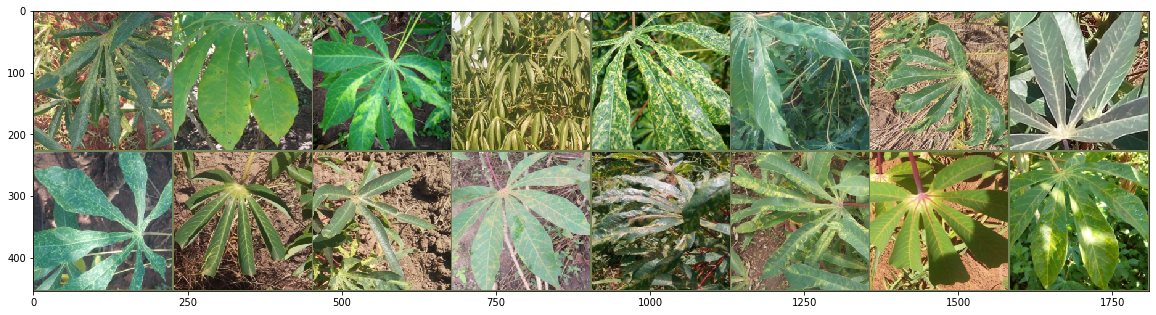

In [41]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid, one_channel=False)

In [37]:

class Additional(nn.Module):
    def __init__(self,modelA,modelB,in_features_a,in_features_b,nb_classes=5,freeze_A = True,freeze_B = True,drop=0.3):
        super(Additional, self).__init__()
        
        self.modelA = modelA
        self.modelB = modelB
        
#         # Remove last linear layer
#         self.modelA.fc = nn.Identity() # for resnet
#         self.modelB.fc = nn.Identity() # for resnet

        self.modelA.last_linear = nn.Identity() #for re_renext
        self.modelB.last_linear = nn.Identity() #for re_renext
        
#         self.modelA.classifier = nn.Identity()    # densenet201
#         self.modelB.classifier = nn.Identity()    # densenet201



        for p in self.modelA.parameters():
            if freeze_A:
                p.requires_grad = False
            else :
                p.requires_grad = True
                
        for p in self.modelB.parameters():
            if freeze_B:
                p.requires_grad = False
            else :
                p.requires_grad = True
                
                
        
        # Create new classifier
        self.last_linear = nn.Linear((in_features_a+in_features_b),(in_features_a+in_features_b)//2)
        self.fc_2 = nn.Linear((in_features_a+in_features_b)//2,  512)
        self.fc_out = nn.Linear( 512, nb_classes)
        
        #Dropout
        self.dropout = nn.Dropout(p=drop)
        
    def forward(self, x):
        #model A
        x1 = self.modelA(x.clone())  
        x1 = x1.view(x1.size(0), -1)
        
        #model B
        x2 = self.modelB(x.clone())  
        x2 = x2.view(x2.size(0), -1)
        
        #concat
        x = torch.cat((x1, x2), dim=1)
        
        x  = self.dropout(self.last_linear(F.relu(x)))
        x = self.dropout(self.fc_2(F.relu(x)))
        x = self.fc_out(F.relu(x))
        
        return x

In [78]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [79]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [80]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [81]:
def test(test_loader, model):
    model.eval()
    pred = []
    _class_labels = np.array(['cbb','cbsd','cgm','cmd','healthy'])
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            images, _ = data
            images = Variable(images).to(device)
    
            outputs = model(images)
    
            prediction = outputs.data.cpu().numpy().argmax()
            
            _predicted_class_labels = _class_labels[prediction]
            
            pred.append(_predicted_class_labels)

    return pred

In [82]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = 'resnet50_vs_resnext101_64x4d'
modelA = pretrainedmodels.resnet50(num_classes=1000, pretrained="imagenet")
modelB = pretrainedmodels.resnext101_64x4d(num_classes=1000, pretrained="imagenet")

In [83]:
# modelA

In [84]:

num_fitsa = modelA.last_linear.in_features
num_fitsb = modelB.last_linear.in_features
print(num_fitsa,num_fitsb)


model = Additional(modelA,modelB,num_fitsa,num_fitsb, freeze_A = False, freeze_B = False)
model = model.to(device)
# model

2048 2048


In [85]:
lr = 2e-4 # 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


epoch_num = 20
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(valid_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        torch.save(model.state_dict(), model_name+'freeze_'+str(best_val_acc)[:4]+'.ckpt')
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 566], [train loss 1.19572], [train acc 0.55875]
[epoch 1], [iter 200 / 566], [train loss 1.11263], [train acc 0.58813]
[epoch 1], [iter 300 / 566], [train loss 1.06605], [train acc 0.60667]
[epoch 1], [iter 400 / 566], [train loss 1.04519], [train acc 0.61750]
[epoch 1], [iter 500 / 566], [train loss 1.03188], [train acc 0.62125]
------------------------------------------------------------
[epoch 1], [val loss 0.80693], [val acc 0.73005]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.80693], [val acc 0.73005]
*****************************************************
[epoch 2], [iter 100 / 566], [train loss 0.92589], [train acc 0.66250]
[epoch 2], [iter 200 / 566], [train loss 0.89161], [train acc 0.67625]
[epoch 2], [iter 300 / 566], [train loss 0.88824], [train acc 0.67917]
[epoch 2], [iter 400 / 566], [train loss 0.87367], [train acc 0.68563]
[epoch 2], [iter 500

## **Submission**

In [ ]:
class_names = {0:'cbsd', 1: 'cgm', 2: 'cbb', 3: 'healthy', 4: 'cmd'}

In [ ]:
def process_image(image_dir):
    # Process a PIL image for use in a PyTorch model
    # tensor.numpy().transpose(1, 2, 0)
    image = Image.open(image_dir)
    preprocess = transforms.Compose([ transforms.Resize(224),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                      transforms.Normalize(mean=mean,std=std)])
    image = preprocess(image)
    # Convert 2D image to 1D vector
    image = np.expand_dims(image, 0)
    image = torch.from_numpy(image)
    inputs = image.to(device)
    return inputs

In [ ]:
# Using our model to predict the label
def predict(image, model):
    # Pass the image through our model
    output = model(image)
    # Reverse the log function in our output
    output = torch.exp(output)
    # Get the top predicted class, and the output percentage for
    # that class
    probs, classes = output.topk(1, dim=1)
    return probs.item(), classes.item()

In [ ]:
test_directory = "./data/test/test/0"
predictions, test_image_fileName = [], []
try:
    test_images = listdir(test_directory)
    for images in test_images:
        test_image_fileName.append(images)
        image = process_image(f'{test_directory}/{images}')
        top_prob, top_class = predict(image, model)
        predictions.append(class_names[top_class])
except Exception as e:
    print(e)

In [ ]:
print("[INFO] Creating pandas dataframe")
submission_data = {"Category":predictions,"Id":test_image_fileName,}
submission_data_frame = pd.DataFrame(submission_data)

In [ ]:
submission_data_frame.head()

In [ ]:
submission_data_frame.to_csv('submission'+model_name+'_freeze_86_flip.csv', header=True, index=False)